## Explanation
This code is used to create Figure 2 a) and b) of publication xy.

In [10]:
import numpy as np
from ruamel.yaml import YAML
from underestimating_hyperplanes import lower_hull_planes, calculate_max_values, get_pel_n_func, sample_over_grid_nd

to ensure that the figures look like in the publication, a certain style-file is loaded

In [2]:
import matplotlib.pyplot as plt
plt.style.use("../FST.mplstyle")

fan data is loaded

In [3]:
def load_yaml_config(path):
    yaml = YAML(typ="safe")
    with open(path, 'r') as f:
        data = yaml.load(f)
    return data

fan_data = load_yaml_config("input_fan_example_data.yaml")

## Definition of electrical power consumption po and power loss $po^\mathrm{Loss}$

The characteristic curve coefficients $a$ ($\alpha$ in paper) and $b$ ($\beta$ in paper) are loaded. With their help, the electric power consumption as a function of $q$ and $n$ is defined as well as its derivative with respect to $q$ and the power loss function.


In [4]:
a = fan_data["Fan2"]["d"][0.2]["pressure_curve"]
b = fan_data["Fan2"]["d"][0.2]["power_curve"]

max_values = calculate_max_values(a, b)
Qmax, dpmax, Pmax = max_values.values()

pel_expr = lambda q, n: b[1] * q**3 + b[2] * q**2*n + b[3] * q*n**2 + b[4]*n**3 + b[5]
pel_expr_grad = lambda q, n: 3*b[1]*q**2 + 2*b[2]*q*n + b[3]*n**2

ploss_func, ploss_func_grad, n_func = get_pel_n_func(a,b)


dp = lambda q: a[1]*q**2 + a[2]*q + a[3]

ploss_expr = lambda q: b[1] * q**3 + b[2] * q**2 + b[3] * q + b[4] + b[5] - dp(q)*q


## Overestimation

The overestimation of the fan curve is computed. The grid points for evaluating the tangents is linearly spaced. This is done by computing the underestimation of the negative power loss and negating the result.

In [5]:
points = np.linspace(Qmax * 1e-9, Qmax, 20)

points = np.column_stack((points, -ploss_expr(points)))

# compute lower hull planes of -ploss
tangential_planes_overestimation = lower_hull_planes(points)

# mirror on x-axis (equivalent to upper hull planes of ploss)
tangential_planes_overestimation[:,:-1] = -tangential_planes_overestimation[:,:-1]

## Underestimation

The underestimation of the fan curve is computed. The grid points are linearly spaced in $q$ and $\Delta p$.

In [6]:
q_vals = np.linspace(Qmax * 1e-9, Qmax, 20)
dp_vals = np.linspace(dpmax * 1e-9, dpmax, 20)

# n_func works as a constraint here, so that n(q,dp)<=1
points = sample_over_grid_nd([q_vals, dp_vals], n_func, )

q_vals = np.linspace(0, Qmax, 20)
dp_vals = np.linspace(0, dpmax, 20)

finer_points = sample_over_grid_nd([q_vals, dp_vals], n_func)

compute the underestimation

In [7]:
from underestimating_hyperplanes import compute_tangential_planes_equation, remove_intersecting_hyperplanes, tangential_planes_to_array

tangential_planes_underestimation = compute_tangential_planes_equation(points, ploss_func, ploss_func_grad)

# this step is only necessary as the fan curves are non-convex
tangential_planes_underestimation = remove_intersecting_hyperplanes(
    tangential_planes_underestimation, ploss_func, finer_points
)

tangential_planes_underestimation = tangential_planes_to_array(tangential_planes_underestimation)

# Apply thresholding to only the first three columns
tangential_planes_underestimation[:, :3] = np.where(np.abs(tangential_planes_underestimation[:, :3]) < 1e-6, 0, tangential_planes_underestimation[:, :3])


## Plot results

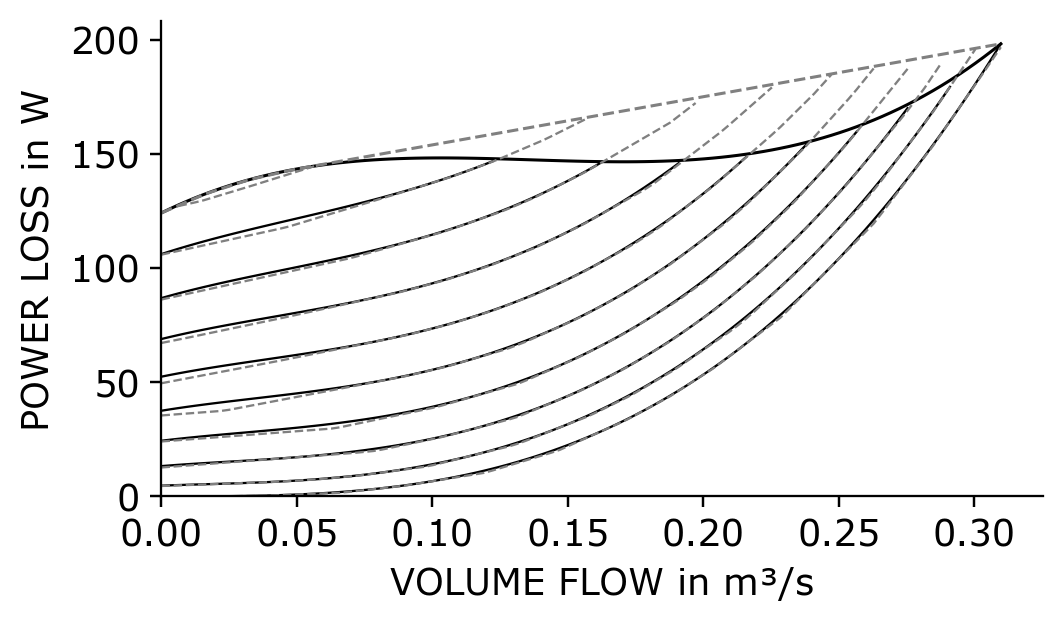

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


qs = np.linspace(0, Qmax, 100)  # domain in x
dps = np.linspace(0, dpmax, 10)    # discrete set of y-values to "sweep" over

plt.figure(figsize=(5, 3))

def f_overestimate_tangential(tangential_planes):
    return min(z0 + mx*qi for (z0, mx, _) in tangential_planes)

def f_underestimate_tangential(tangential_planes_under):
    return max(z0 + mx*qi + my*dpi for (z0, mx, my, _ , _) in tangential_planes_under)


plt.plot(qs, ploss_expr(qs), "-", color="k", linewidth=1)

simplice_over_vals, tangential_over_vals = [], []
tangential_over_vals = []
for qi in qs:
    tangential_over_vals.append(f_overestimate_tangential(tangential_planes_overestimation))
plt.plot(qs, tangential_over_vals, '--', color="grey", linewidth=1)


for dpi in dps:
    qn_real = np.array([qi for idx, qi in enumerate(qs) if n_func(qi,dpi) <= 1])
    plt.plot(qn_real, ploss_func(qn_real, dpi), "-", color="k")

    simplice_under_vals, tangential_under_vals = [], []
    tangential_under_vals = []
    for qi in qs:
        tangential_under_vals.append(f_underestimate_tangential(tangential_planes_underestimation))


    qn = np.where(np.array(tangential_over_vals) >= np.array(tangential_under_vals),qs,np.nan)
    plt.plot(qn, tangential_under_vals, '--', color="grey")


plt.xlabel("VOLUME FLOW in m³/s")
plt.ylabel("POWER LOSS in W")

plt.ylim(bottom=0)
plt.xlim(left=0)

plt.tight_layout()

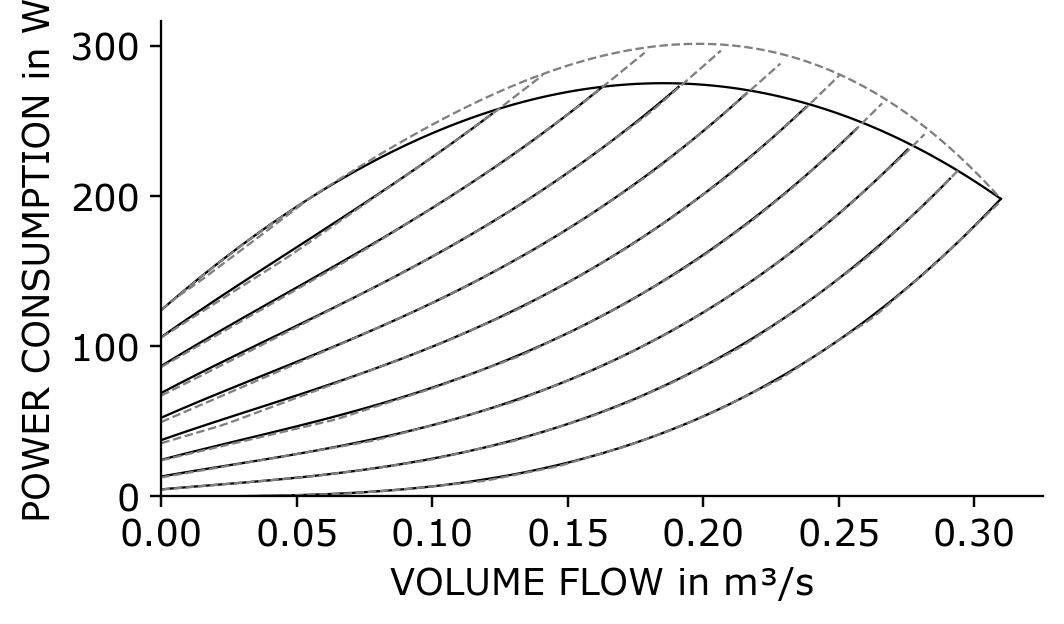

In [9]:
import numpy as np
import matplotlib.pyplot as plt


qs = np.linspace(0, Qmax, 100)  # domain in x
dps = np.linspace(0, dpmax, 10)    # discrete set of y-values to "sweep" over

plt.figure(figsize=(5, 3))

def f_overestimate_tangential(tangential_planes):
    return min(z0 + mx*qi for (z0, mx, _) in tangential_planes)

def f_underestimate_tangential(tangential_planes_under):
    return max(z0 + mx*qi + my*dpi for (z0, mx, my, _ , _) in tangential_planes_under)


plt.plot(qs, ploss_expr(qs)+ dp(qs)*qs, "-", color="k")

simplice_over_vals, tangential_over_vals = [], []
tangential_over_vals = []
for qi in qs:
    tangential_over_vals.append(f_overestimate_tangential(tangential_planes_overestimation))
plt.plot(qs, tangential_over_vals+ dp(qs)*qs, '--', color="grey")


for dpi in dps:
    qn_real = np.array([qi for qi in qs if n_func(qi,dpi) <= 1])
    plt.plot(qn_real, ploss_func(qn_real, dpi) + qn_real*dpi, "-", color="k")

    simplice_under_vals, tangential_under_vals = [], []
    tangential_under_vals = []
    for qi in qs:
        tangential_under_vals.append(f_underestimate_tangential(tangential_planes_underestimation))


    qn = np.where(np.array(tangential_over_vals) + qs*dp(qs) >= np.array(tangential_under_vals) + dpi*qs,qs,np.nan)
    plt.plot(qn, tangential_under_vals + dpi*qn, '--', color="grey")


plt.xlabel("VOLUME FLOW in m³/s")
plt.ylabel("POWER CONSUMPTION in W")

plt.ylim(bottom=0)
plt.xlim(left=0)
plt.tight_layout()